# EOSC 454/556B Assignment 2: Question 3
## Finite Data Effects - Downsampling and Interpolation

In this question, we explore what happens when we have a limited amount of data.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d, CubicSpline

# Set plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Setup: Reuse functions from Question 2

In [4]:
def compute_interval_velocity(t, v0, alpha, beta, omega):
    """
    Compute interval velocity as a function of time.
    """
    v_int = v0 + alpha * np.sin(omega * t) + beta * t
    return v_int


def compute_rms_velocity(t, v0, alpha, beta, omega):
    """
    Compute RMS velocity numerically.
    """
    V_rms = np.zeros_like(t)
    
    for i, t_val in enumerate(t):
        if t_val == 0:
            V_rms[i] = v0
        else:
            u = np.linspace(0, t_val, 500)
            v_int_u = compute_interval_velocity(u, v0, alpha, beta, omega)
            integral = integrate.simpson(v_int_u**2, x=u)
            V_rms[i] = np.sqrt(integral / t_val)
    
    return V_rms


def estimate_interval_from_rms(t, V_rms):
    """
    Estimate interval velocity from RMS velocity using finite differences.
    """
    v_int_est = np.zeros_like(V_rms)
    dV_dt = np.zeros_like(V_rms)
    
    # Forward difference for first point
    dV_dt[0] = (V_rms[1] - V_rms[0]) / (t[1] - t[0])
    
    # Central difference for interior points
    for i in range(1, len(t) - 1):
        dV_dt[i] = (V_rms[i+1] - V_rms[i-1]) / (t[i+1] - t[i-1])
    
    # Backward difference for last point
    dV_dt[-1] = (V_rms[-1] - V_rms[-2]) / (t[-1] - t[-2])
    
    # Compute interval velocity
    for i, t_val in enumerate(t):
        if t_val == 0:
            v_int_est[i] = V_rms[i]
        else:
            bracket_term = 1 + (2 * t_val * dV_dt[i]) / V_rms[i]
            if bracket_term < 0:
                bracket_term = 0
            v_int_est[i] = V_rms[i] * np.sqrt(bracket_term)
    
    return v_int_est

In [5]:
# Define parameters (same as Q2)
v0 = 2000  # m/s
alpha = 50  # m/s
beta = 20  # m/s²
f = 1  # Hz
omega = 2 * np.pi * f  # rad/s

# Create fine time grid (original)
n_points = 200
t_fine = np.linspace(0, 2, n_points)

# Compute true interval and RMS velocities on fine grid
v_int_true = compute_interval_velocity(t_fine, v0, alpha, beta, omega)
V_rms_true = compute_rms_velocity(t_fine, v0, alpha, beta, omega)

print(f"Original grid: {n_points} points")
print(f"Time step: {t_fine[1] - t_fine[0]:.4f} s")

Original grid: 200 points
Time step: 0.0101 s


## Question 3(a): Downsample the data

We will downsample by taking every n-th data point. Let's choose n = 10 for moderate downsampling.

In [6]:
# Choose decimation factor
n = 10  # Take every 10th point

# Downsample the data
t_coarse = t_fine[::n]
V_rms_coarse = V_rms_true[::n]

print(f"Decimation factor: n = {n}")
print(f"Downsampled grid: {len(t_coarse)} points")
print(f"Downsampled time step: {t_coarse[1] - t_coarse[0]:.4f} s")
print(f"Data reduction: {(1 - len(t_coarse)/len(t_fine))*100:.1f}%")

Decimation factor: n = 10
Downsampled grid: 20 points
Downsampled time step: 0.1005 s
Data reduction: 90.0%


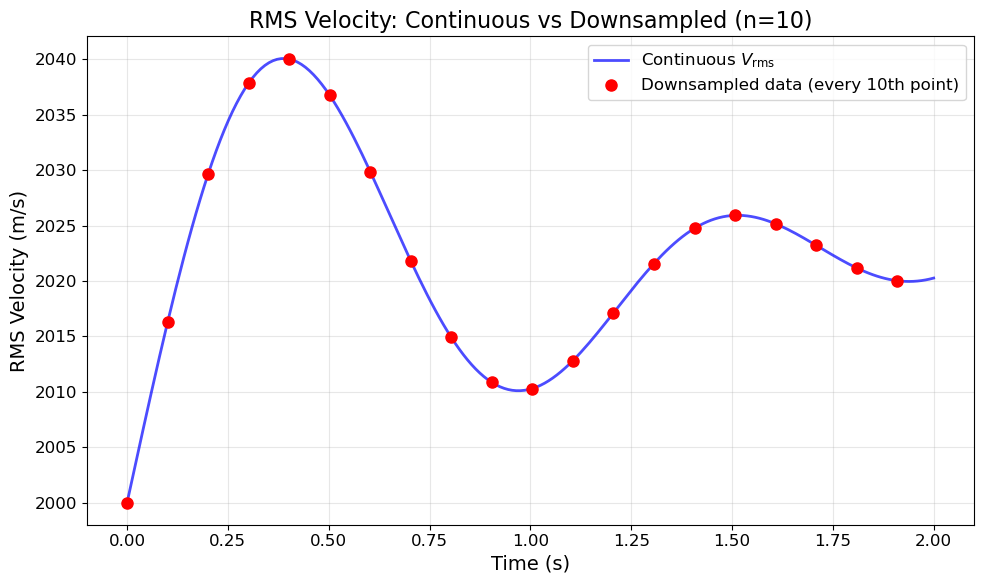

In [7]:
# Plot the RMS velocity with downsampled points
plt.figure(figsize=(10, 6))
plt.plot(t_fine, V_rms_true, 'b-', linewidth=2, label='Continuous $V_{\\text{rms}}$', alpha=0.7)
plt.plot(t_coarse, V_rms_coarse, 'ro', markersize=8, label=f'Downsampled data (every {n}th point)')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('RMS Velocity (m/s)', fontsize=14)
plt.title(f'RMS Velocity: Continuous vs Downsampled (n={n})', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('q3a_downsampled.png', dpi=300, bbox_inches='tight')
plt.show()

## Question 3(b): Linear Interpolation

Now we interpolate the downsampled RMS data back onto the original fine grid using linear interpolation.

In [8]:
# Linear interpolation
linear_interp = interp1d(t_coarse, V_rms_coarse, kind='linear', fill_value='extrapolate')
V_rms_linear = linear_interp(t_fine)

# Estimate interval velocity from interpolated RMS
v_int_linear = estimate_interval_from_rms(t_fine, V_rms_linear)

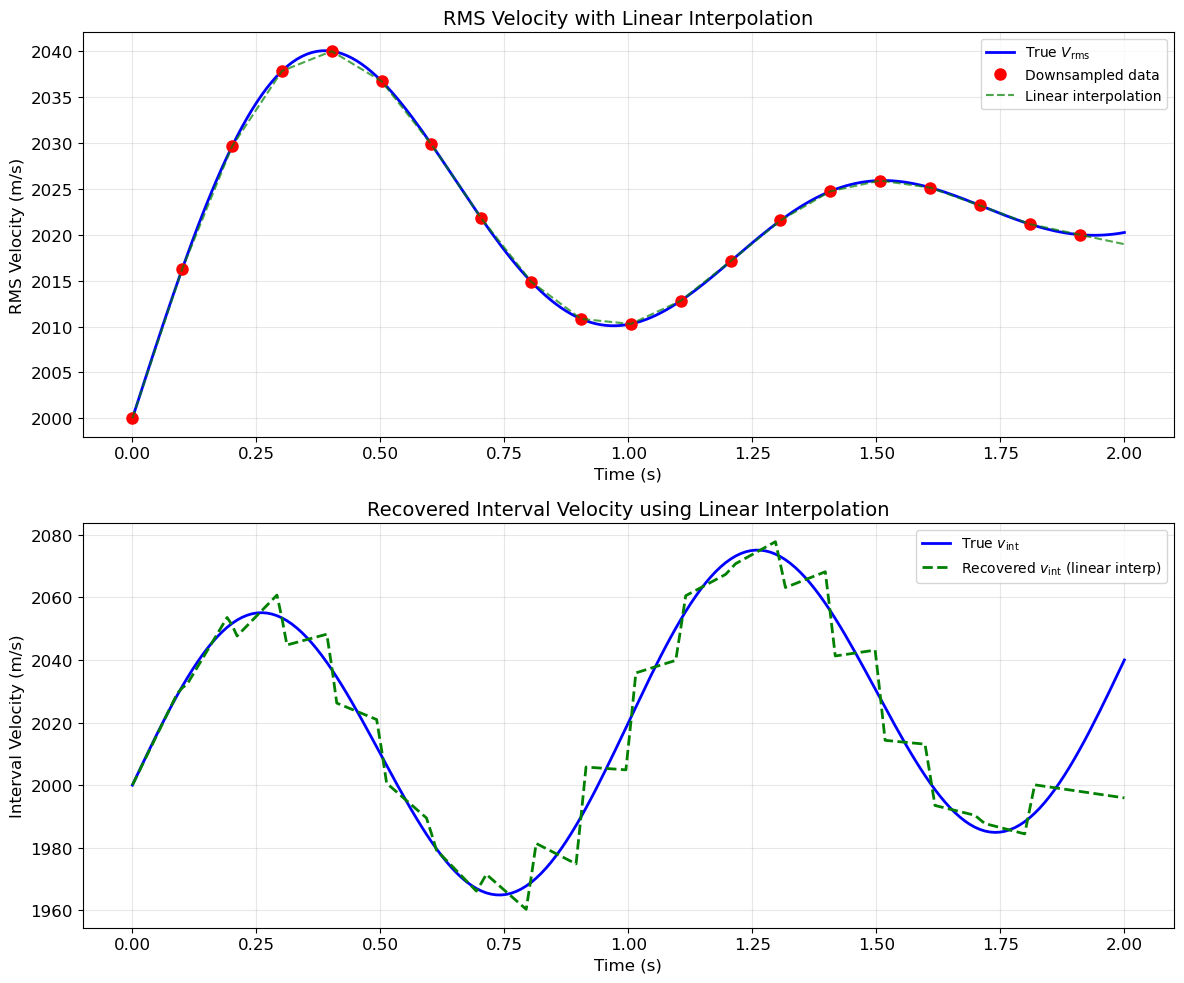

Linear interpolation error:
  Max error: 44.0758 m/s
  Mean error: 4.9024 m/s


In [9]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top panel: RMS velocity
ax = axes[0]
ax.plot(t_fine, V_rms_true, 'b-', linewidth=2, label='True $V_{\\text{rms}}$')
ax.plot(t_coarse, V_rms_coarse, 'ro', markersize=8, label='Downsampled data')
ax.plot(t_fine, V_rms_linear, 'g--', linewidth=1.5, label='Linear interpolation', alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('RMS Velocity (m/s)', fontsize=12)
ax.set_title('RMS Velocity with Linear Interpolation', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom panel: Recovered interval velocity
ax = axes[1]
ax.plot(t_fine, v_int_true, 'b-', linewidth=2, label='True $v_{\\text{int}}$')
ax.plot(t_fine, v_int_linear, 'g--', linewidth=2, label='Recovered $v_{\\text{int}}$ (linear interp)')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Interval Velocity (m/s)', fontsize=12)
ax.set_title('Recovered Interval Velocity using Linear Interpolation', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3b_linear_interp.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate error
error_linear = np.abs(v_int_true - v_int_linear)
print(f"Linear interpolation error:")
print(f"  Max error: {error_linear.max():.4f} m/s")
print(f"  Mean error: {error_linear.mean():.4f} m/s")

## Question 3(c): Cubic Spline Interpolation

Now we use cubic spline interpolation, which should provide smoother results.

In [10]:
# Cubic spline interpolation
cubic_spline = CubicSpline(t_coarse, V_rms_coarse)
V_rms_cubic = cubic_spline(t_fine)

# Estimate interval velocity from spline-interpolated RMS
v_int_cubic = estimate_interval_from_rms(t_fine, V_rms_cubic)

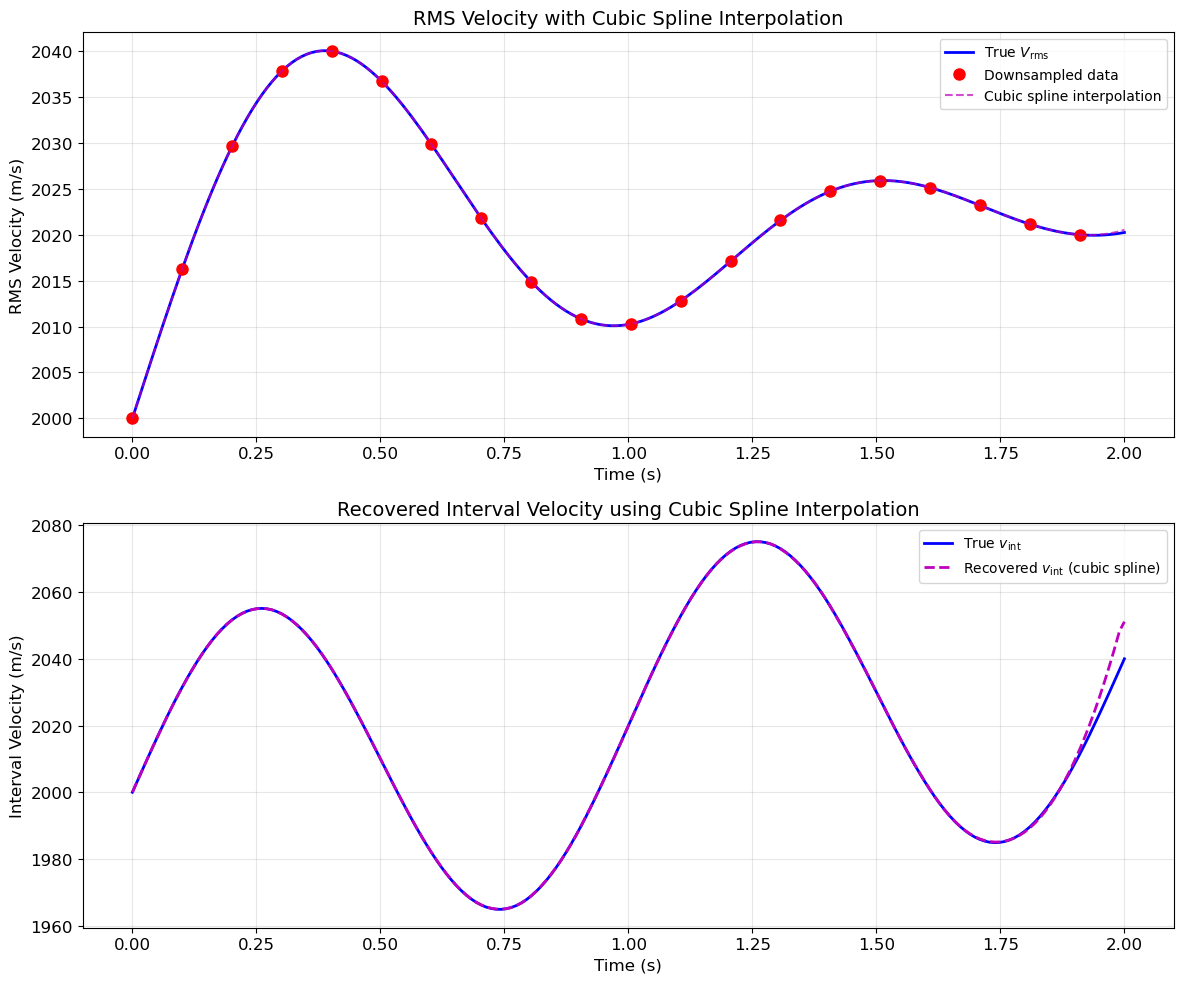

Cubic spline interpolation error:
  Max error: 11.5964 m/s
  Mean error: 0.3702 m/s


In [11]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top panel: RMS velocity
ax = axes[0]
ax.plot(t_fine, V_rms_true, 'b-', linewidth=2, label='True $V_{\\text{rms}}$')
ax.plot(t_coarse, V_rms_coarse, 'ro', markersize=8, label='Downsampled data')
ax.plot(t_fine, V_rms_cubic, 'm--', linewidth=1.5, label='Cubic spline interpolation', alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('RMS Velocity (m/s)', fontsize=12)
ax.set_title('RMS Velocity with Cubic Spline Interpolation', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom panel: Recovered interval velocity
ax = axes[1]
ax.plot(t_fine, v_int_true, 'b-', linewidth=2, label='True $v_{\\text{int}}$')
ax.plot(t_fine, v_int_cubic, 'm--', linewidth=2, label='Recovered $v_{\\text{int}}$ (cubic spline)')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Interval Velocity (m/s)', fontsize=12)
ax.set_title('Recovered Interval Velocity using Cubic Spline Interpolation', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3c_cubic_spline.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate error
error_cubic = np.abs(v_int_true - v_int_cubic)
print(f"Cubic spline interpolation error:")
print(f"  Max error: {error_cubic.max():.4f} m/s")
print(f"  Mean error: {error_cubic.mean():.4f} m/s")

## Question 3(d): Multiple Decimation Levels

Compare results at three different decimation levels.

In [12]:
# Define three decimation levels
decimation_levels = [5, 10, 20]  # Light, moderate, heavy decimation

# Store results
results = {}

for n_dec in decimation_levels:
    # Downsample
    t_down = t_fine[::n_dec]
    V_rms_down = V_rms_true[::n_dec]
    
    # Linear interpolation
    linear_interp_temp = interp1d(t_down, V_rms_down, kind='linear', fill_value='extrapolate')
    V_rms_lin = linear_interp_temp(t_fine)
    v_int_lin = estimate_interval_from_rms(t_fine, V_rms_lin)
    
    # Cubic spline interpolation
    cubic_spline_temp = CubicSpline(t_down, V_rms_down)
    V_rms_cub = cubic_spline_temp(t_fine)
    v_int_cub = estimate_interval_from_rms(t_fine, V_rms_cub)
    
    # Store results
    results[n_dec] = {
        't_down': t_down,
        'V_rms_down': V_rms_down,
        'V_rms_linear': V_rms_lin,
        'V_rms_cubic': V_rms_cub,
        'v_int_linear': v_int_lin,
        'v_int_cubic': v_int_cub,
        'n_points': len(t_down)
    }
    
print("Decimation summary:")
for n_dec in decimation_levels:
    print(f"n={n_dec}: {results[n_dec]['n_points']} points")

Decimation summary:
n=5: 40 points
n=10: 20 points
n=20: 10 points


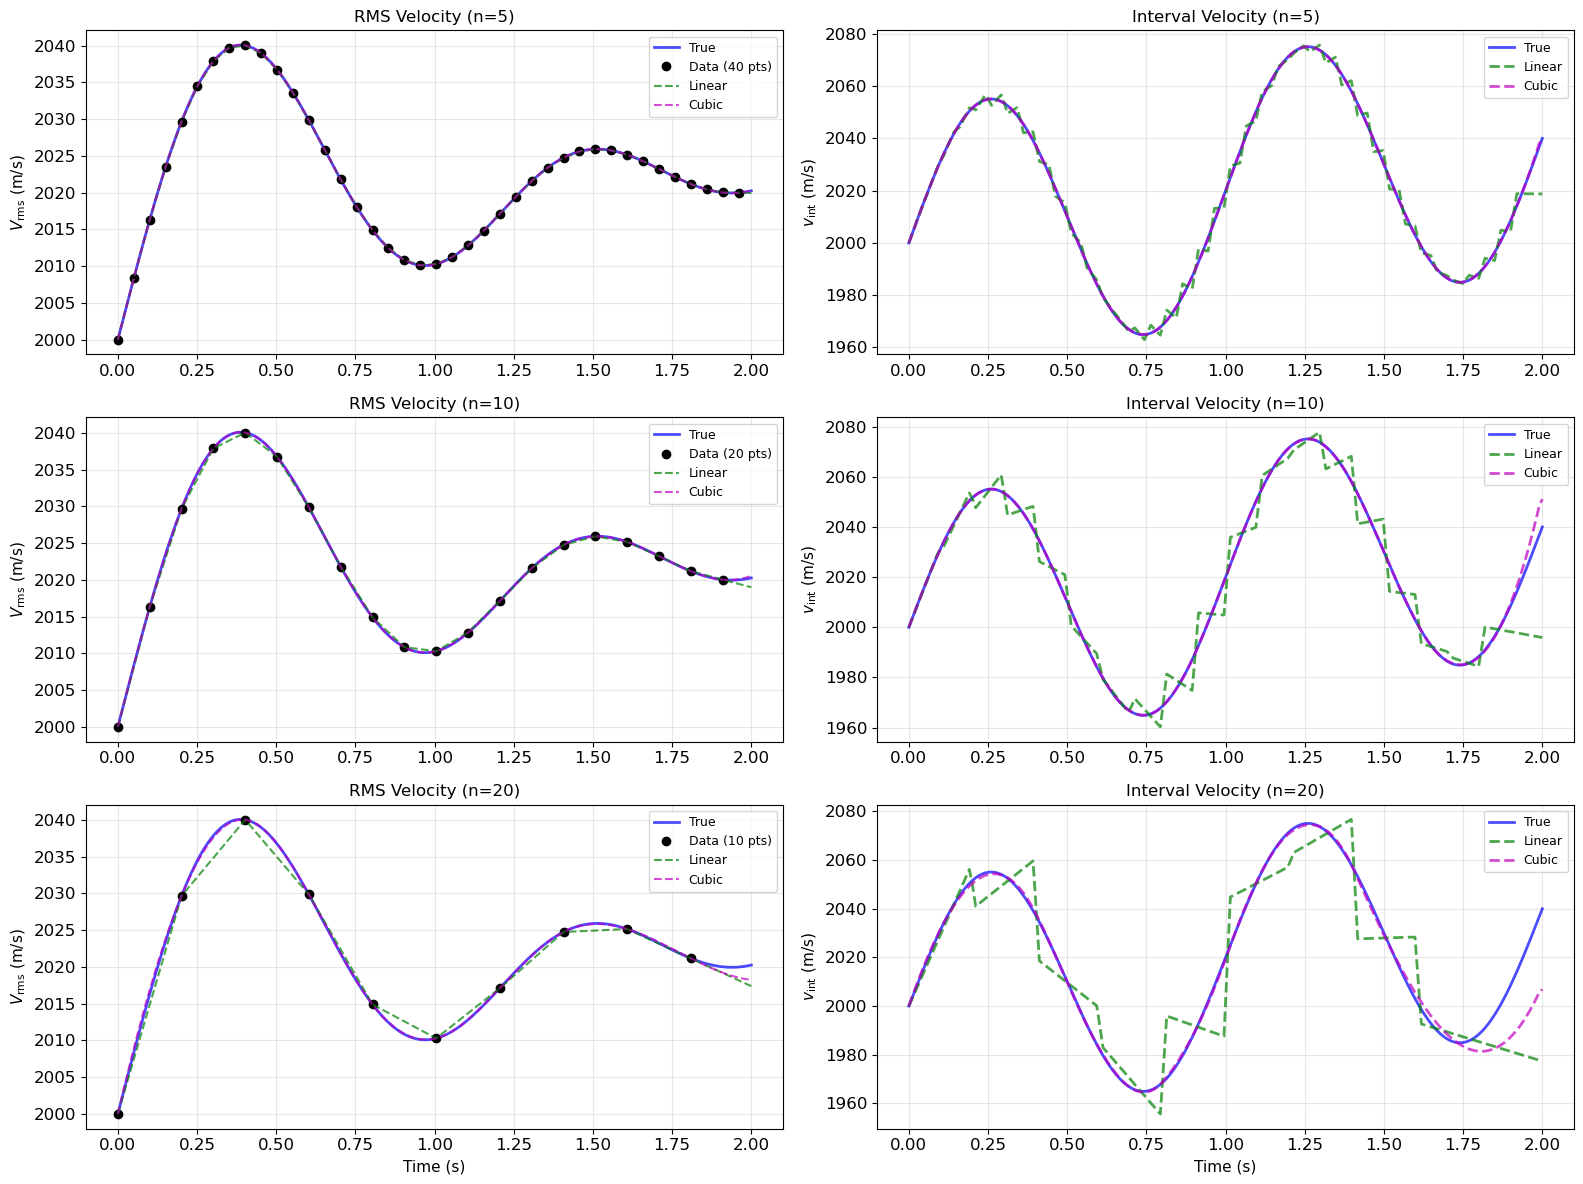

In [13]:
# Create comprehensive comparison plot
fig = plt.figure(figsize=(16, 12))

# Create 3x2 subplot grid
for idx, n_dec in enumerate(decimation_levels):
    # RMS velocity plots (left column)
    ax = plt.subplot(3, 2, 2*idx + 1)
    ax.plot(t_fine, V_rms_true, 'b-', linewidth=2, label='True', alpha=0.7)
    ax.plot(results[n_dec]['t_down'], results[n_dec]['V_rms_down'], 'ko', 
            markersize=6, label=f'Data ({results[n_dec]["n_points"]} pts)')
    ax.plot(t_fine, results[n_dec]['V_rms_linear'], 'g--', linewidth=1.5, 
            label='Linear', alpha=0.7)
    ax.plot(t_fine, results[n_dec]['V_rms_cubic'], 'm--', linewidth=1.5, 
            label='Cubic', alpha=0.7)
    ax.set_ylabel('$V_{\\text{rms}}$ (m/s)', fontsize=11)
    ax.set_title(f'RMS Velocity (n={n_dec})', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    if idx == 2:
        ax.set_xlabel('Time (s)', fontsize=11)
    
    # Interval velocity plots (right column)
    ax = plt.subplot(3, 2, 2*idx + 2)
    ax.plot(t_fine, v_int_true, 'b-', linewidth=2, label='True', alpha=0.7)
    ax.plot(t_fine, results[n_dec]['v_int_linear'], 'g--', linewidth=2, 
            label='Linear', alpha=0.7)
    ax.plot(t_fine, results[n_dec]['v_int_cubic'], 'm--', linewidth=2, 
            label='Cubic', alpha=0.7)
    ax.set_ylabel('$v_{\\text{int}}$ (m/s)', fontsize=11)
    ax.set_title(f'Interval Velocity (n={n_dec})', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    if idx == 2:
        ax.set_xlabel('Time (s)', fontsize=11)

plt.tight_layout()
plt.savefig('q3d_decimation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Compute and display errors for each decimation level
print("\n" + "="*70)
print("ERROR ANALYSIS FOR DIFFERENT DECIMATION LEVELS")
print("="*70)

for n_dec in decimation_levels:
    error_lin = np.abs(v_int_true - results[n_dec]['v_int_linear'])
    error_cub = np.abs(v_int_true - results[n_dec]['v_int_cubic'])
    
    print(f"\nDecimation n={n_dec} ({results[n_dec]['n_points']} points):")
    print(f"  Linear interpolation:")
    print(f"    Max error:  {error_lin.max():.4f} m/s")
    print(f"    Mean error: {error_lin.mean():.4f} m/s")
    print(f"  Cubic spline interpolation:")
    print(f"    Max error:  {error_cub.max():.4f} m/s")
    print(f"    Mean error: {error_cub.mean():.4f} m/s")


ERROR ANALYSIS FOR DIFFERENT DECIMATION LEVELS

Decimation n=5 (40 points):
  Linear interpolation:
    Max error:  21.2501 m/s
    Mean error: 1.8206 m/s
  Cubic spline interpolation:
    Max error:  1.3296 m/s
    Mean error: 0.0337 m/s

Decimation n=10 (20 points):
  Linear interpolation:
    Max error:  44.0758 m/s
    Mean error: 4.9024 m/s
  Cubic spline interpolation:
    Max error:  11.5964 m/s
    Mean error: 0.3702 m/s

Decimation n=20 (10 points):
  Linear interpolation:
    Max error:  62.6570 m/s
    Mean error: 10.1976 m/s
  Cubic spline interpolation:
    Max error:  33.0965 m/s
    Mean error: 2.8370 m/s


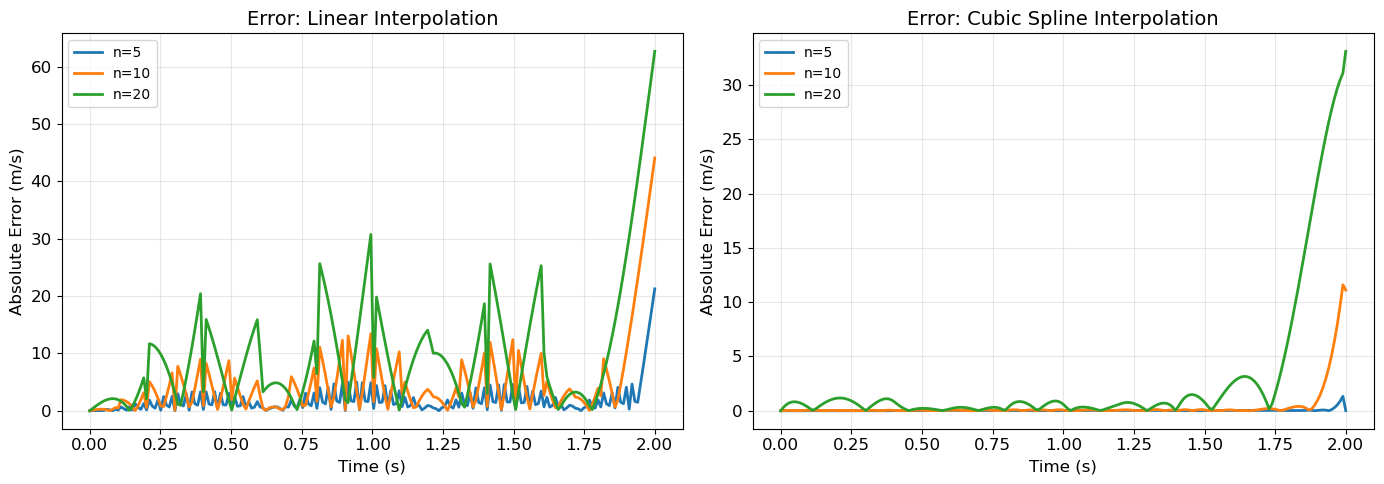

In [15]:
# Create error plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear interpolation errors
ax = axes[0]
for n_dec in decimation_levels:
    error = np.abs(v_int_true - results[n_dec]['v_int_linear'])
    ax.plot(t_fine, error, linewidth=2, label=f'n={n_dec}')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Absolute Error (m/s)', fontsize=12)
ax.set_title('Error: Linear Interpolation', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Cubic spline interpolation errors
ax = axes[1]
for n_dec in decimation_levels:
    error = np.abs(v_int_true - results[n_dec]['v_int_cubic'])
    ax.plot(t_fine, error, linewidth=2, label=f'n={n_dec}')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Absolute Error (m/s)', fontsize=12)
ax.set_title('Error: Cubic Spline Interpolation', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3d_error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Discussion for Question 3(d)

**Observations:**

1. **Effect of decimation level:**
   - As decimation increases (fewer data points), the recovered interval velocity deviates more from the true model
   - Higher decimation leads to loss of information about rapid variations

2. **Linear vs Cubic Spline:**
   - Cubic spline generally performs better than linear interpolation
   - Linear interpolation creates "kinked" derivatives, which affect the recovered interval velocity
   - Cubic spline provides smoother interpolation and better captures the underlying trends

3. **Trade-offs:**
   - Light decimation (n=5): Both methods work reasonably well
   - Moderate decimation (n=10): Cubic spline significantly outperforms linear
   - Heavy decimation (n=20): Both methods struggle, but cubic spline is still better

**Key insight:** The derivative operation in the inversion formula is sensitive to interpolation smoothness, making cubic spline interpolation preferable for this application.